# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [7]:
%pip install kaggle

In [8]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download alxmamaev/flowers-recognition
# ! unzip flowers-recognition.zip

In [10]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

print(data_dir)

data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir



/root/.keras/datasets/flower_photos.tar
total 223460
drwxr-x--- 7 270850 5000      4096 Feb 10  2016 flower_photos
-rw-r--r-- 1 root   root 228813984 Nov 21 09:18 flower_photos.tar


In [33]:
!rm /root/.keras/datasets/flower_photos/LICENSE.txt
# !ls -l /root/.keras/datasets/flower_photos

!rm -rf /kaggle/working/dataset
!cp -r /root/.keras/datasets/flower_photos/ /kaggle/working/dataset
!ls -l /kaggle/working/dataset

DATASET_DIR = '/kaggle/working/dataset'

rm: cannot remove '/root/.keras/datasets/flower_photos/LICENSE.txt': No such file or directory
total 196
drwx------ 2 root root 36864 Nov 21 09:26 daisy
drwx------ 2 root root 49152 Nov 21 09:26 dandelion
drwx------ 2 root root 36864 Nov 21 09:26 roses
drwx------ 2 root root 36864 Nov 21 09:26 sunflowers
drwx------ 2 root root 40960 Nov 21 09:26 tulips


### On verifie qu'on a un GPU 

In [14]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission deniedCollecting gputil  Downloading GPUtil-1.4.0.tar.gz (5.5 kB)  Preparing metadata (setup.py) ... doneBuilding wheels for collected packages: gputil  Building wheel for gputil (setup.py) ... done  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=04c5f8d82ce7f85828dee30345ed8fe6ce6025dacd949ca226310ba731f9b492  Stored in directory: /home/logic/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3Successfully built gputilInstalling collected packages: gputilSuccessfully installed gputil-1.4.0[notice] A new release of pip is available: 23.0.1 -> 24.3.1[notice] To update, run: python -m pip install --upgrade pipRequirement already satisfied: psutil in /home/logic/.pyenv/versions/3.9.20/envs/tf_intel/lib/python3.9/site-packages (6.1.0)[notice] A new release of pip is available: 23.0.1 -> 24.3.1[notice] To update, run: python -m pip install --upgrade pipCollecting 

### On import les librairies

In [34]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
print(tf.__version__)
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers


2.16.1


In [35]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [36]:
# original dataset folder, you can see above
flowers_path = Path(DATASET_DIR)

## On prepare explore la dataset

In [37]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['dandelion', 'daisy', 'roses', 'tulips', 'sunflowers']


In [38]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,dandelion,/kaggle/working/dataset/dandelion/340190928_d7...
1,dandelion,/kaggle/working/dataset/dandelion/158988663_6f...
2,dandelion,/kaggle/working/dataset/dandelion/4696437766_8...
3,dandelion,/kaggle/working/dataset/dandelion/8748402330_c...
4,dandelion,/kaggle/working/dataset/dandelion/2597655841_0...


In [39]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  3670
Flowers in each category: 
category
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64


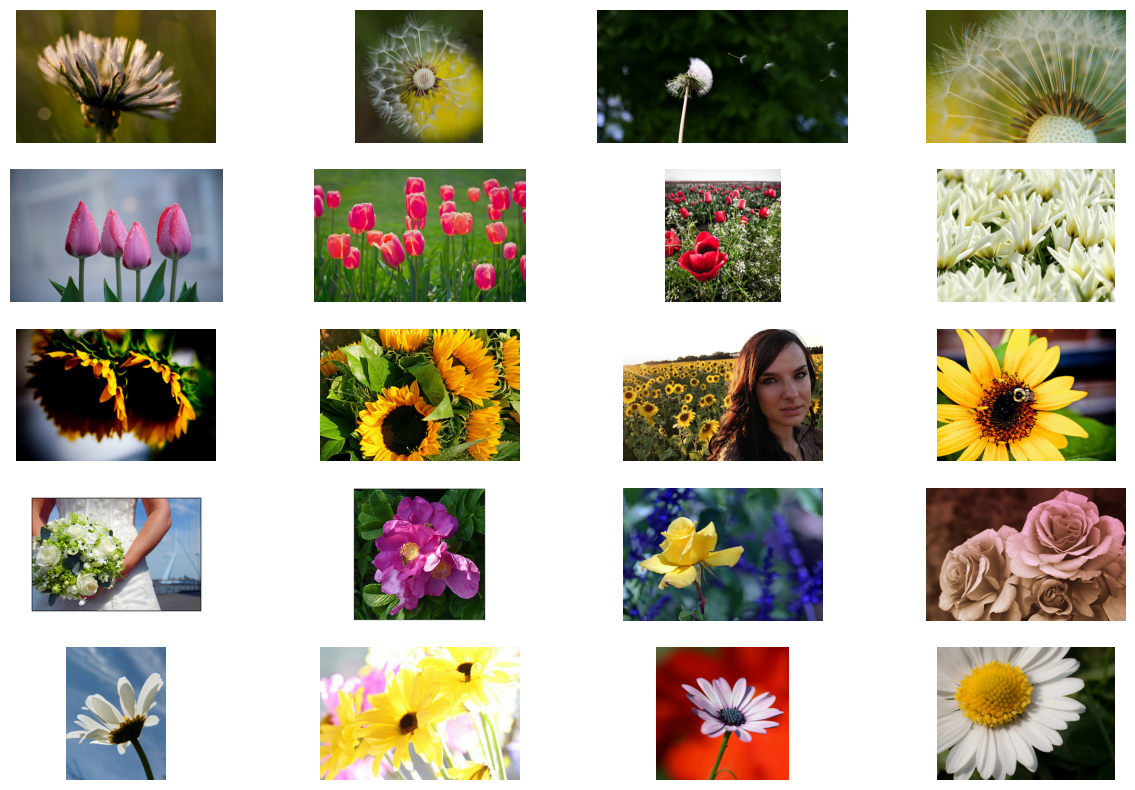

In [40]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

### On va créer deux dossier 'Train' et 'Valid' pour notre modéle

In [41]:
# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulips
%mkdir -p train/sunflowers
%mkdir -p train/roses
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulips
%mkdir -p valid/sunflowers
%mkdir -p valid/roses
%mkdir -p valid/dandelion

%cd ..

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working/data
/kaggle/working


### On import nos catégories dans les deux dossiers 

In [42]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory

    print(samples[0])
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/train/' + str(category) + '/' + name)

/kaggle/working/dataset/dandelion/340190928_d77bf4d615.jpg
/kaggle/working/dataset/tulips/4681062529_36186617d9.jpg
/kaggle/working/dataset/sunflowers/13354458753_7b586f7c95_n.jpg
/kaggle/working/dataset/roses/7683456068_02644b8382_m.jpg
/kaggle/working/dataset/daisy/5883162120_dc7274af76_n.jpg


### Comme modéle, on utilise VGG16 qui est un modéle Pretrained

In [43]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [44]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

## Feature Extraction

In [46]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(240, 240),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 3170 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [50]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [53]:
history = {}


history = model.fit(
        train_generator,
        epochs=2, # originally 30 epochs
        validation_data=validation_generator)

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732181458.472700     408 service.cc:145] XLA service 0x5c1c5fa87b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732181458.472783     408 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732181482.926942     408 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 82/100 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - acc: 0.2245 - loss: 1.6847

I0000 00:00:1732181520.061399     411 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 220 bytes spill stores, 320 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 48 bytes spill stores, 56 bytes spill loads



100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 511ms/step - acc: 0.2282 - loss: 1.6737 - val_acc: 0.2360 - val_loss: 1.6045
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - acc: 0.2958 - loss: 1.5671 - val_acc: 0.3840 - val_loss: 1.3208


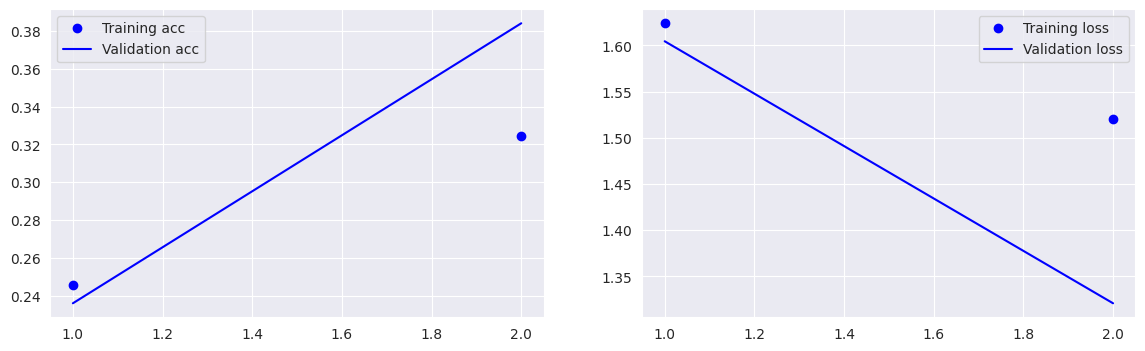

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [55]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

Validation Accuracy:  0.3840000033378601


# Fine Tuning

In [56]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [65]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=3,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 400ms/step - acc: 0.3980 - loss: 0.4879 - val_acc: 0.4560 - val_loss: 0.4090
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4560 - val_loss: 0.4090
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - acc: 0.4758 - loss: 0.3998 - val_acc: 0.4800 - val_loss: 0.3885


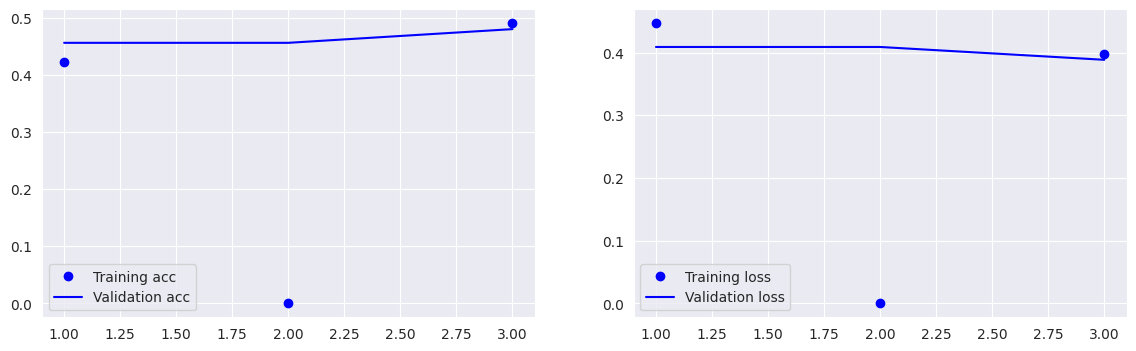

In [68]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [69]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.47999998927116394


### 85% Accuracy using VGG16.